# **Load and Inspect the Dataset**

In [ ]:
import pandas as pd

df = pd.read_csv("IMDB Dataset.csv", on_bad_lines='skip')
print(df.head())
print(f"Dataset shape: {df.shape}")

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Dataset shape: (50000, 2)


## **Dataset Size**


In [ ]:
total_reviews = len(df)
positive_reviews = sum(df['sentiment'] == 'positive')
negative_reviews = sum(df['sentiment'] == 'negative')

print(f"Total reviews: {total_reviews}")
print(f"Positive reviews: {positive_reviews}")
print(f"Negative reviews: {negative_reviews}")

Total reviews: 50000
Positive reviews: 25000
Negative reviews: 25000


## **Class Distribution**

In [ ]:
print(df['sentiment'].value_counts(normalize=True) * 100)

sentiment
positive    50.0
negative    50.0
Name: proportion, dtype: float64


## **Review Length Statistics**

In [ ]:
df['review_length_words'] = df['review'].apply(lambda x: len(str(x).split()))
df['review_length_chars'] = df['review'].apply(lambda x: len(str(x)))

print("Review length (words):")
print(df['review_length_words'].describe())
print("Review length (characters):")
print(df['review_length_chars'].describe())


Review length (words):
count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: review_length_words, dtype: float64
Review length (characters):
count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review_length_chars, dtype: float64


## **Example Reviews**

In [ ]:
print("Example positive review:\n", df[df['sentiment'] == 'positive'].iloc[0]['review'])
print("Example negative review:\n", df[df['sentiment'] == 'negative'].iloc[0]['review'])


Example positive review:
 One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of 

## **Plotting**

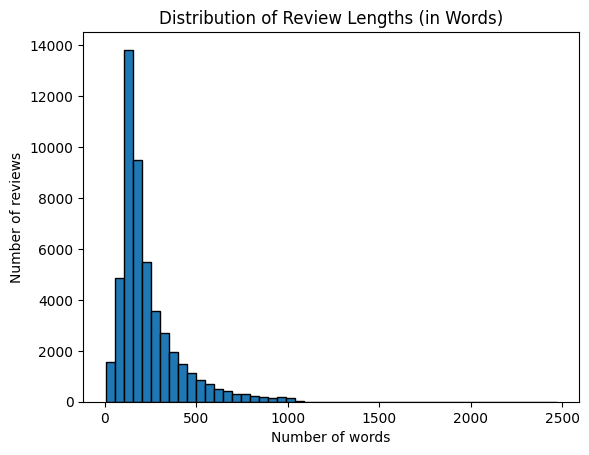

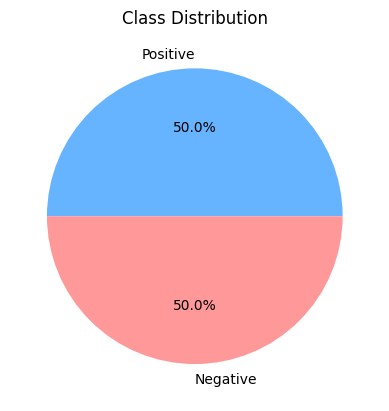

In [ ]:
import matplotlib.pyplot as plt

# Histogram of review lengths
plt.hist(df['review_length_words'], bins=50, edgecolor='k')
plt.title('Distribution of Review Lengths (in Words)')
plt.xlabel('Number of words')
plt.ylabel('Number of reviews')
plt.show()

# Pie chart for class distribution
df['sentiment'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#66b3ff','#ff9999'], labels=['Positive', 'Negative'])
plt.title('Class Distribution')
plt.ylabel('')
plt.show()


# **Preprocessing The Data**

In [ ]:
import re

def clean_review(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Strip leading/trailing whitespace
    text = text.strip()
    return text

# Apply cleaning
df['clean_review'] = df['review'].apply(clean_review)

# For BERT-uncased, lowercase
df['clean_review'] = df['clean_review'].str.lower()

## **Label Encoding**

In [ ]:
label_map = {'positive': 1, 'negative': 0}
df['label'] = df['sentiment'].map(label_map)


## **Splitting The Data**

In [ ]:
from sklearn.model_selection import train_test_split

# 1. Split into train+val (90%) and test (10%)
df_trainval, df_test = train_test_split(
    df, test_size=0.1, stratify=df['label'], random_state=42
)

# 2. Split train+val into train (80%) and val (10% of original data)
df_train, df_val = train_test_split(
    df_trainval, test_size=0.1111, stratify=df_trainval['label'], random_state=42
)

print(f"Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")

Train: 40000, Val: 5000, Test: 5000


## **Tokenization for BERT**

In [ ]:
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 256

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

# Prepare each split
train_encodings = tokenize(df_train['clean_review'].tolist())
val_encodings   = tokenize(df_val['clean_review'].tolist())
test_encodings  = tokenize(df_test['clean_review'].tolist())

train_labels = df_train['label'].tolist()
val_labels   = df_val['label'].tolist()
test_labels  = df_test['label'].tolist()

class IMDBDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDBDataset(train_encodings, train_labels)
val_dataset   = IMDBDataset(val_encodings, val_labels)
test_dataset  = IMDBDataset(test_encodings, test_labels)

# **BERT Fine Tuning**

In [ ]:
!pip install transformers torch scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, classification_report, f1_score
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm


## **Initialize Model**

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## **Training Setup**

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=8, shuffle=False)

optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 3  # Can be 2-4 depending on resources

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


## **Training Loop**

In [ ]:
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    train_preds = []
    train_true = []
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Collect train predictions for accuracy
        logits = outputs.logits
        train_preds += list(torch.argmax(logits, dim=1).cpu().numpy())
        train_true += list(labels.cpu().numpy())

    avg_train_loss = total_loss / len(train_loader)
    train_acc = accuracy_score(train_true, train_preds)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_preds, val_true = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            val_preds += list(torch.argmax(logits, dim=1).cpu().numpy())
            val_true += list(labels.cpu().numpy())
    val_acc = accuracy_score(val_true, val_preds)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Training loss = {avg_train_loss:.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")


Epoch 1 Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 1 Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1: Training loss = 0.2389, Train Acc = 0.9031, Val Acc = 0.9238


Epoch 2 Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 2 Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2: Training loss = 0.1128, Train Acc = 0.9590, Val Acc = 0.9260


Epoch 3 Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 3 Validation:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3: Training loss = 0.0404, Train Acc = 0.9881, Val Acc = 0.9262


## **Evaluation on Validation set**

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0     0.9193    0.9344    0.9268      2500
           1     0.9333    0.9180    0.9256      2500

    accuracy                         0.9262      5000
   macro avg     0.9263    0.9262    0.9262      5000
weighted avg     0.9263    0.9262    0.9262      5000



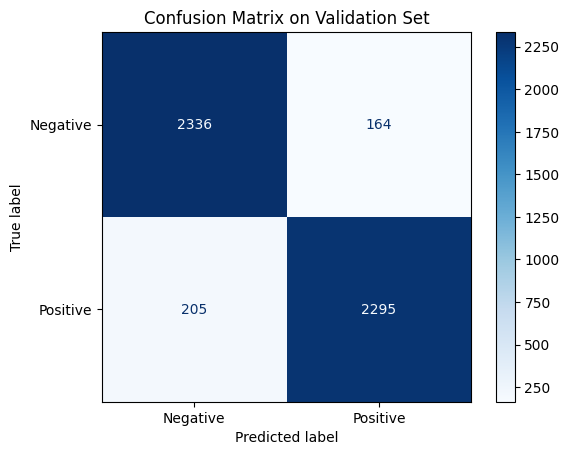

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
print("Classification Report on Validation Set:")
print(classification_report(val_true, val_preds, digits=4))

cm = confusion_matrix(val_true, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Validation Set')
plt.show()

## **Testing the Model on Test set**

Test Evaluation:   0%|          | 0/625 [00:00<?, ?it/s]

Classification Report on Test Set:
              precision    recall  f1-score   support

           0     0.9308    0.9312    0.9310      2500
           1     0.9312    0.9308    0.9310      2500

    accuracy                         0.9310      5000
   macro avg     0.9310    0.9310    0.9310      5000
weighted avg     0.9310    0.9310    0.9310      5000



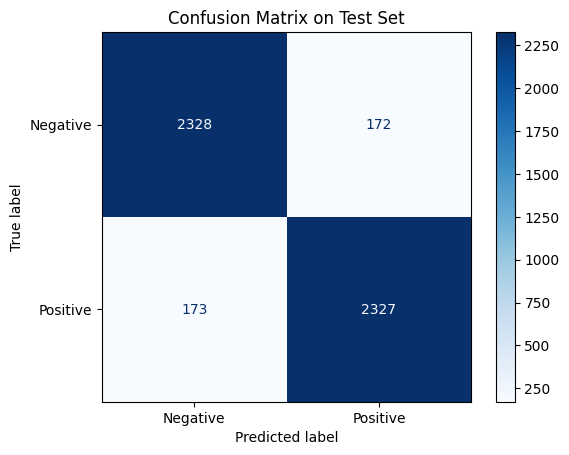

In [ ]:
model.eval()
test_preds, test_true = [], []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test Evaluation"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        test_preds += list(torch.argmax(logits, dim=1).cpu().numpy())
        test_true += list(labels.cpu().numpy())

print("Classification Report on Test Set:")
print(classification_report(test_true, test_preds, digits=4))

cm = confusion_matrix(test_true, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Test Set')
plt.show()


# **Train Score VS Validation Score**

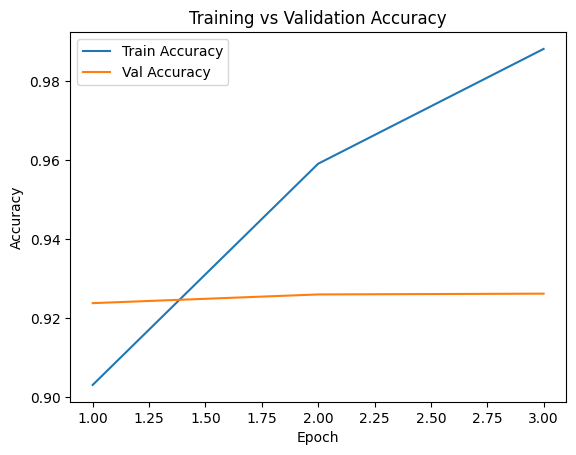

In [ ]:
epochs_range = range(1, epochs+1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
